In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

setup_notebook()

In [2]:
from datasets.stocks_data_wrapper import StocksDataWrapper
from helpers.data_helper import *
from helpers.plots_helper import *

In [3]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'IBM'
price_column = 'Close'
project_label='KerasLSTMRegression'

predict_n = 10

In [4]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", 
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,1962-03-21,0.015428,0.014523,0.015787,0.015429,0.005020,0.003780,0.002525,0.595025,0.000000,...,0.014503,0.013555,0.013679,0.619962,0.394439,0.596761,0.496869,higher,0.012863,lower
1,1962-03-22,0.015334,0.014334,0.015533,0.015051,0.004897,0.003456,0.000000,0.456905,0.001641,...,0.014474,0.013587,0.013637,0.619512,0.394997,0.595125,0.477865,lower,0.013540,higher
2,1962-03-23,0.015113,0.014271,0.015565,0.015177,0.004938,0.002700,0.000000,0.505305,0.000410,...,0.014436,0.013619,0.013618,0.619054,0.395653,0.594787,0.474037,higher,0.013508,lower
3,1962-03-26,0.015207,0.014334,0.015597,0.015162,0.004933,0.001944,0.001263,0.499957,0.000000,...,0.014399,0.013656,0.013600,0.618669,0.396346,0.594843,0.474674,lower,0.013540,higher
4,1962-03-27,0.015113,0.014114,0.014963,0.014516,0.004723,0.005076,0.000842,0.332912,0.001026,...,0.014300,0.013658,0.013496,0.617898,0.397285,0.592643,0.449242,lower,0.013666,higher


In [5]:
y_column = 'NextPrice'
seq_len = 5
n_splits=10
val_size = 0.2

features = ['Close', 'Volume', 'MACD_diff', 'RSI(14)', 
            'EMA(14)', 'SMA(10)', 'SMA(20) - SMA(10)','PercentageDiff', 'LowLen', 'RSI_diff', 'BodyLen', 'Volume_diff']
datasets_splits = data_wrapper.get_datasets(n_splits=n_splits, val_size=val_size, sequences=True, seq_len=5, y_column=y_column, features_list=features)

datasets_splits.shape

(10, 6)

https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [ ]:
from keras.preprocessing import timeseries_dataset_from_array as build_timeseries_ds
from trainers.keras_regression_trainer import KerasRegressionTrainer
from models.keras_lstm_model import LSTMModel
import tensorflow as tf


config_dict = dict(
    quotation=quotation,
    predict_n = predict_n,
    features=features,
    learning_rate = 0.01,
    batch_size = 32,
    sequence_length=seq_len,
    n_epochs = 50,
    n_splits = n_splits,
    val_size = val_size,
)

group_name = f"[{quotation}] {seq_len}-sequences : {len(features)} features  -> predict:{predict_n}, {n_splits} splits {val_size} val"


for split_id, split in tqdm(enumerate(datasets_splits)):
    #run = wandb.init(project='StockRegressionKerasLSTM', config=config_dict, group=group_name, name=f"Split {split_id+1}")
    
    (X_train, X_val, X_test, y_train, y_val, y_test) = split
    train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(config_dict['batch_size'])
    val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(config_dict['batch_size'])
    test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(config_dict['batch_size'])

    model = LSTMModel(config_dict, seq_len, len(features), output_dim=1,
                      learning_rate=config_dict['learning_rate'], loss='mse', metrics=['mae'])
    trainer = KerasRegressionTrainer(model, project_label=project_label)
    trainer.train(train_set, val_set)

### Train a model with the full training set (train + validation) 

In [16]:
config_dict['n_epochs'] = 150

full_train_set = train_set.concatenate(val_set)
final_model = LSTMModel(config_dict, seq_len, len(features), learning_rate=config_dict['learning_rate'], loss='mse')
trainer = KerasRegressionTrainer(model, project_label=f"{project_label} full training-set")
trainer.train(full_train_set, val_set=test_set)

Wandb run page : https://wandb.ai/ludovic_herbelin_unine/KerasLSTMRegression%20full%20training-set/runs/1o86tsbq


KeyboardInterrupt: 

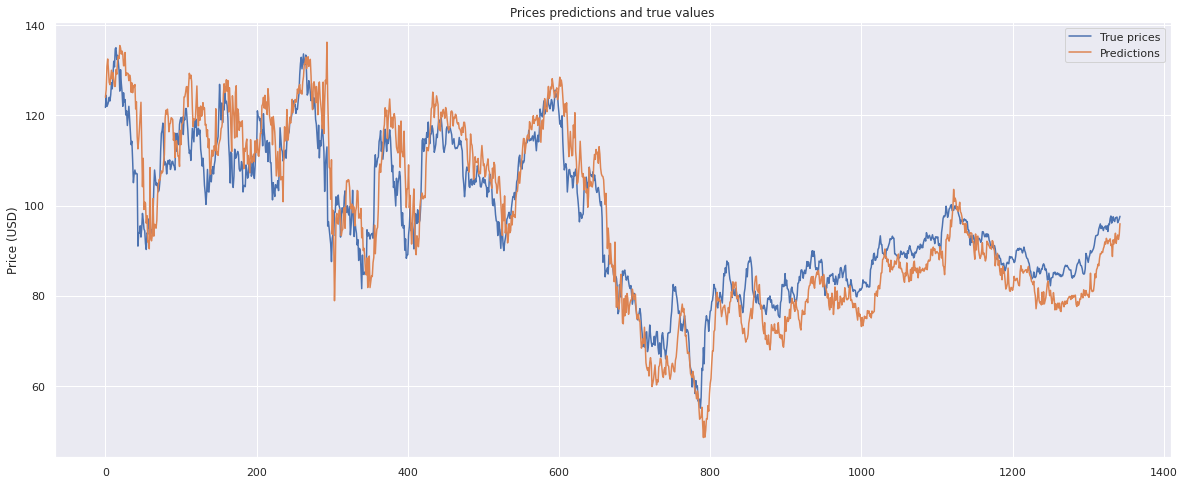

In [18]:
predictions, labels = trainer.predict(test_set)

scaled_preds = data_wrapper.get_unscaled_values(predictions, 'Close')
scaled_labels = data_wrapper.get_unscaled_values(labels, 'Close')

ax = plot_predictions(scaled_labels, scaled_preds)

### Use of lime to explain decisions

In [20]:
import lime
from lime import lime_tabular

# https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset
training_samples = np.concatenate([x for x, y in train_set], axis=0)
training_labels = np.concatenate([y for x, y in train_set], axis=0)


for batch in train_set.take(1):
    inputs, targets = batch

explainer = lime_tabular.RecurrentTabularExplainer(inputs, training_labels=targets,
                                                   discretize_continuous = True,
                                                   feature_names=X_train,
                                                   verbose=True, mode='regression')

In [21]:
test_samples = np.concatenate([x for x, y in val_set], axis=0)

print(test_samples.shape)

(1883, 5, 12)


In [22]:
# https://github.com/marcotcr/lime/blob/master/doc/notebooks/Submodular%20Pick%20examples.ipynb

import warnings
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(texplainer, test_samples, model.predict, 
                                        sample_size=15, num_features=10, num_exps_desired=5)

Intercept 0.08798181587632986
Prediction_local [0.09800279]
Right: 0.13753136
Intercept 0.08618290461168952
Prediction_local [0.10189591]
Right: 0.12039384
Intercept 0.0895815018578277
Prediction_local [0.09280693]
Right: 0.13461837
Intercept 0.08673557327863236
Prediction_local [0.10226207]
Right: 0.1363773
Intercept 0.08923479535431475
Prediction_local [0.09395208]
Right: 0.11604659
Intercept 0.08388942378177185
Prediction_local [0.10894669]
Right: 0.12174871
Intercept 0.08661790522514216
Prediction_local [0.10228231]
Right: 0.1320408
Intercept 0.08435619216941952
Prediction_local [0.10909184]
Right: 0.12259095
Intercept 0.08597539557051848
Prediction_local [0.10417441]
Right: 0.17140362
Intercept 0.08832995514969803
Prediction_local [0.09688338]
Right: 0.124849625
Intercept 0.08987959803430878
Prediction_local [0.09114773]
Right: 0.13207853
Intercept 0.08504111321682925
Prediction_local [0.1058678]
Right: 0.13034509
Intercept 0.09221719534552397
Prediction_local [0.0853741]
Right: 0

[<Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>,
 <Figure size 1440x576 with 1 Axes>]

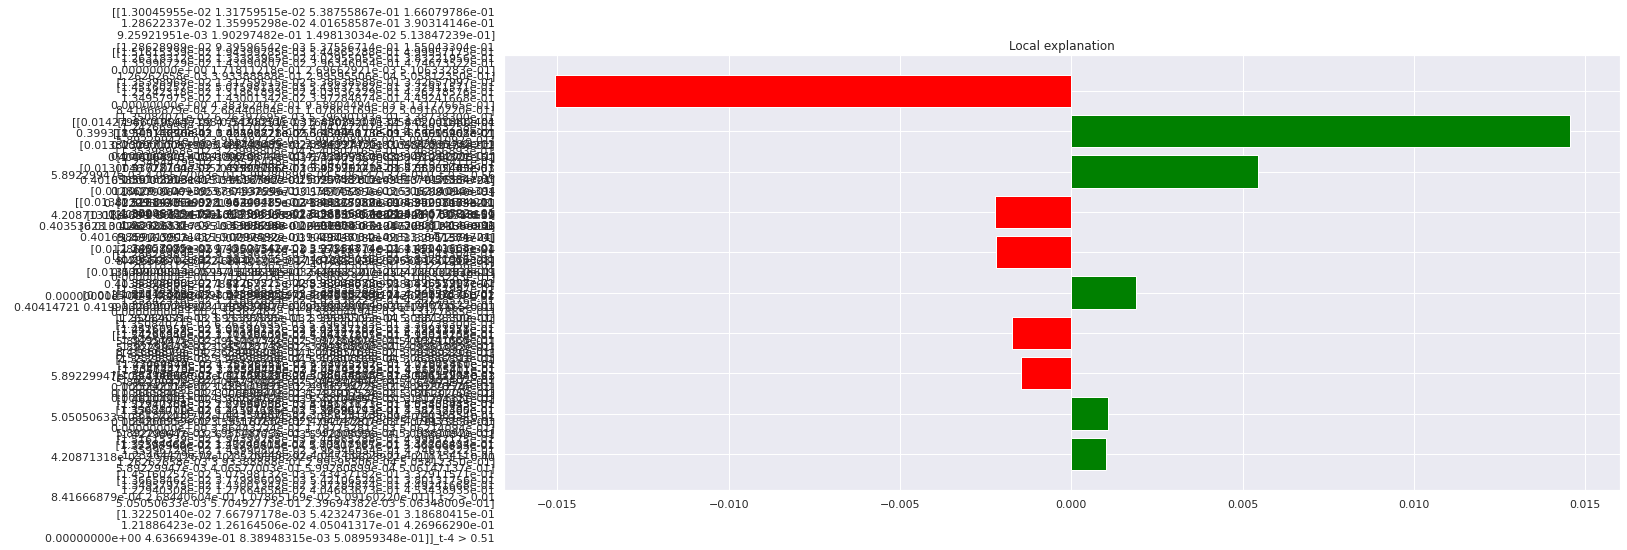

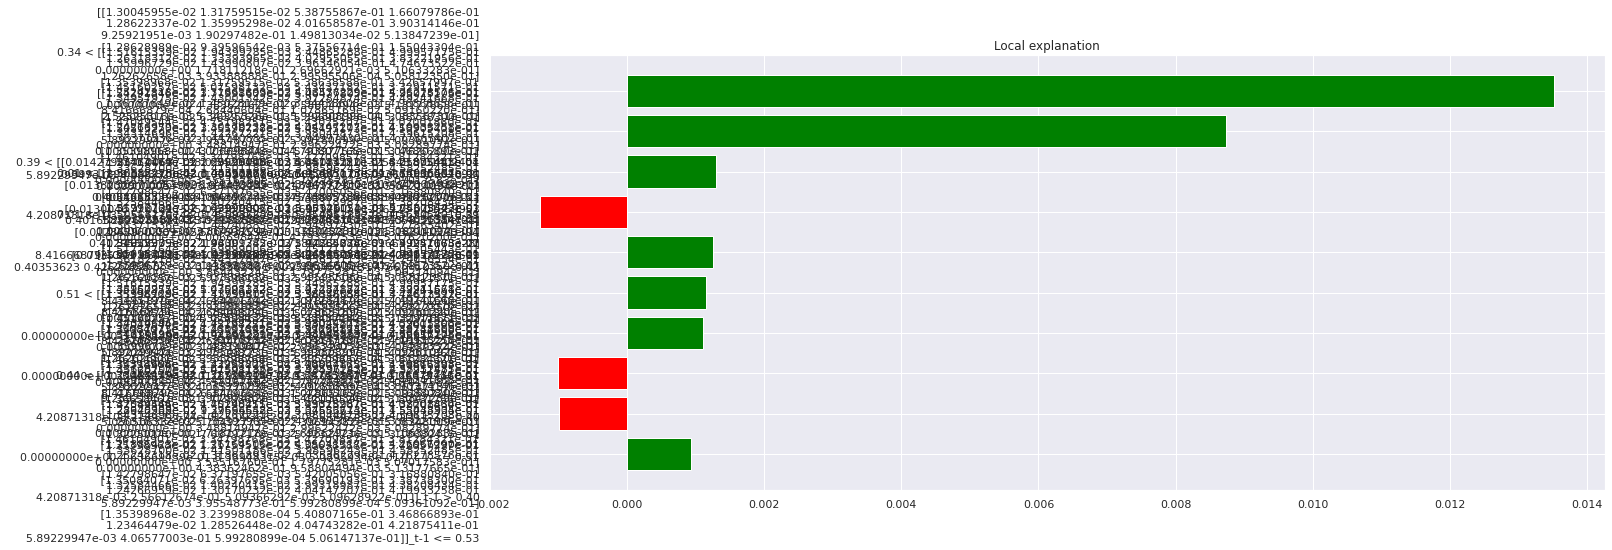

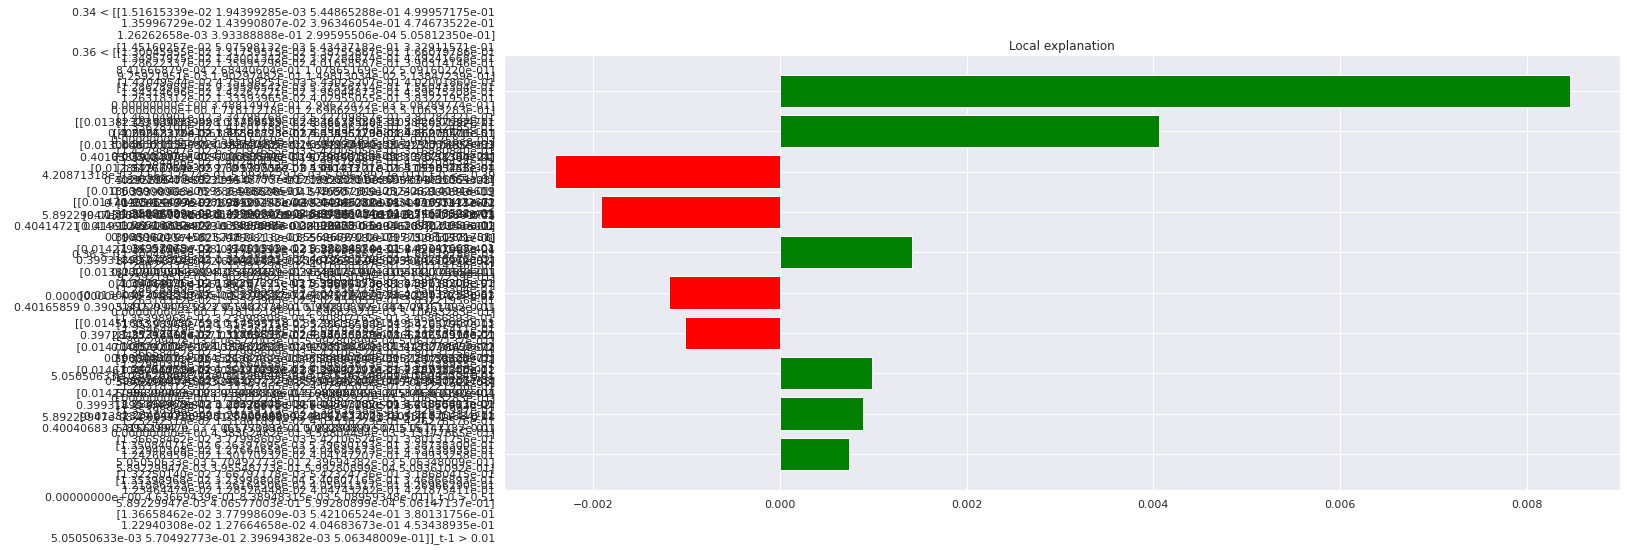

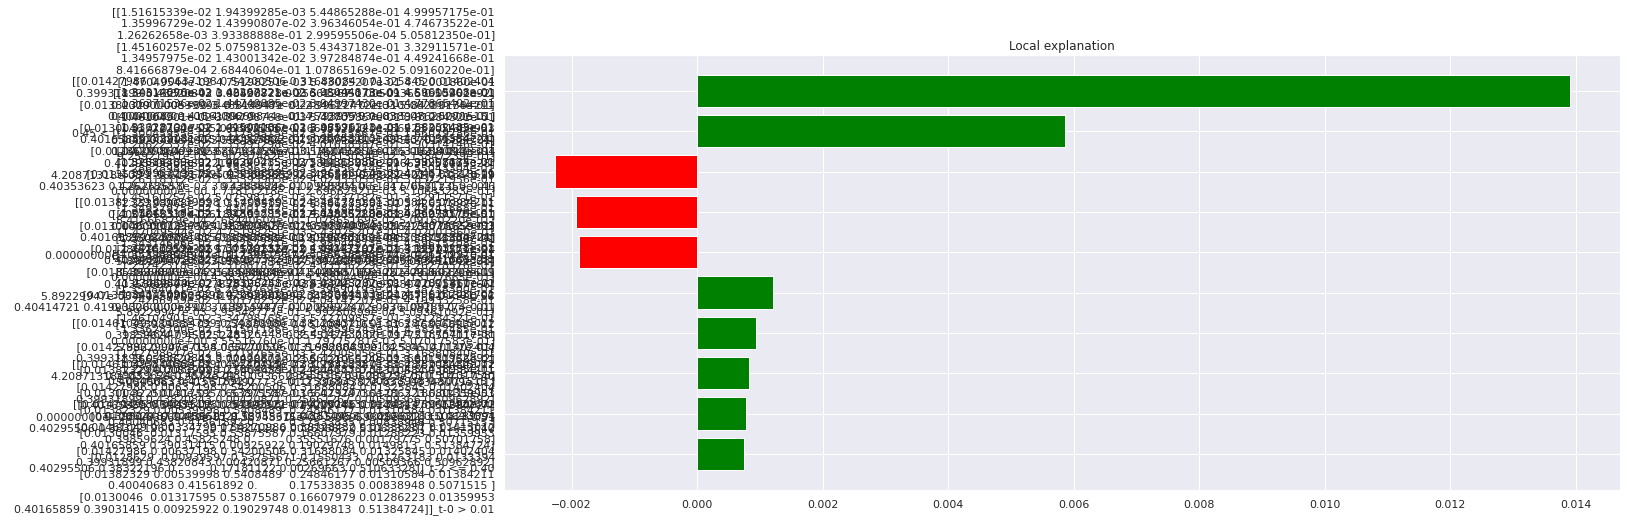

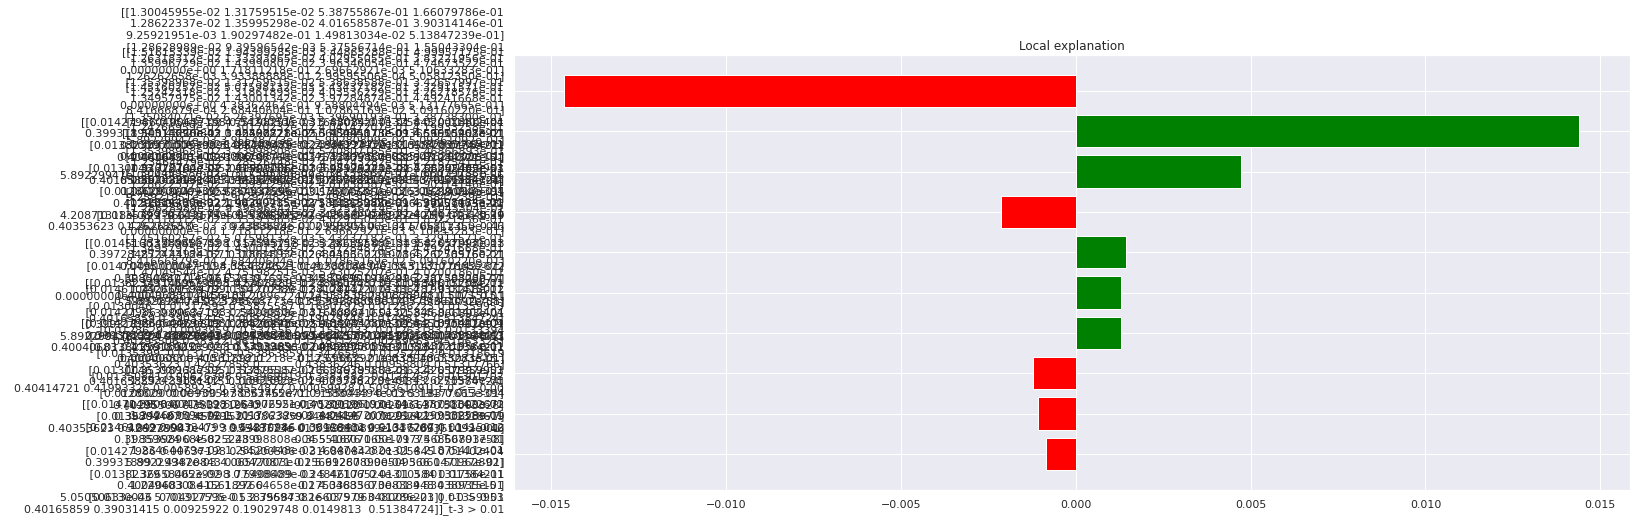

In [24]:
explanations = list(sp_obj.sp_explanations)

#print(len(explanations))

[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations]